## 2.3. Equation

### 2.3.1. Equation (1)

In [5]:
# Libraries:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

In [7]:
cost = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final-data/cost.csv')

cost

,Task ID,Supplier ID,Cost
0,T34,S4,0.307331
1,T34,S5,0.357689
2,T34,S6,0.351982
3,T34,S7,0.303813
4,T34,S8,0.325427
...,...,...,...
7075,T130,S60,0.410605
7076,T130,S61,0.410376
7077,T130,S62,0.407884
7078,T130,S63,0.420536


In [9]:
def calculate_supplier_errors(cost):
    min_cost_per_task = cost.groupby('Task ID')['Cost'].min()

    # Collect task-level details for each supplier
    task_errors_detailed = []

    # Iterate through each supplier
    for supplier in cost['Supplier ID'].unique():
        supplier_costs = cost[cost['Supplier ID'] == supplier]

        # Iterate through each task assigned to this supplier
        for task in supplier_costs['Task ID'].unique():
            # Minimum cost for this task
            min_cost = min_cost_per_task[task]

            supplier_cost = supplier_costs[supplier_costs['Task ID'] == task]['Cost'].values[0]

            # Calculate error for this task
            error = min_cost - supplier_cost

            # Add detailed information for this task
            task_errors_detailed.append({
                'Task ID': task,
                'Supplier ID': supplier,
                'Min Cost': min_cost, 
                'Supplier Cost': supplier_cost, 
                'Error': error 
            })

    # Create a DataFrame for task-level errors
    task_errors_df = pd.DataFrame(task_errors_detailed)

    # Calculate RMSE for each supplier (aggregated)
    rmse_summary = (
        task_errors_df.groupby('Supplier ID')['Error']
        .apply(lambda x: np.sqrt(np.mean(np.square(x))))
        .reset_index()
        .rename(columns={'Error': 'RMSE'})
    )

    return task_errors_df, rmse_summary


In [11]:
error2_3 = calculate_supplier_errors(cost)[0]
error2_3['Squared_Error'] = error2_3['Error']**2
error2_3

,Task ID,Supplier ID,Min Cost,Supplier Cost,Error,Squared_Error
0,T34,S4,0.290967,0.307331,-0.016363,0.000268
1,T35,S4,0.283752,0.297320,-0.013568,0.000184
2,T36,S4,0.284575,0.354568,-0.069993,0.004899
3,T3,S4,0.310395,0.372457,-0.062062,0.003852
4,T7,S4,0.316962,0.346182,-0.029221,0.000854
...,...,...,...,...,...,...
7075,T126,S64,0.387038,0.420607,-0.033570,0.001127
7076,T127,S64,0.394986,0.440728,-0.045742,0.002092
7077,T128,S64,0.417426,0.443202,-0.025776,0.000664
7078,T129,S64,0.387206,0.408710,-0.021505,0.000462


/var/folders/9q/x_qkm_295r77cyh7zn22pj3h0000gn/T/ipykernel_13857/4138981672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=error2_3, x='Supplier ID', y='Squared_Error', palette='coolwarm')


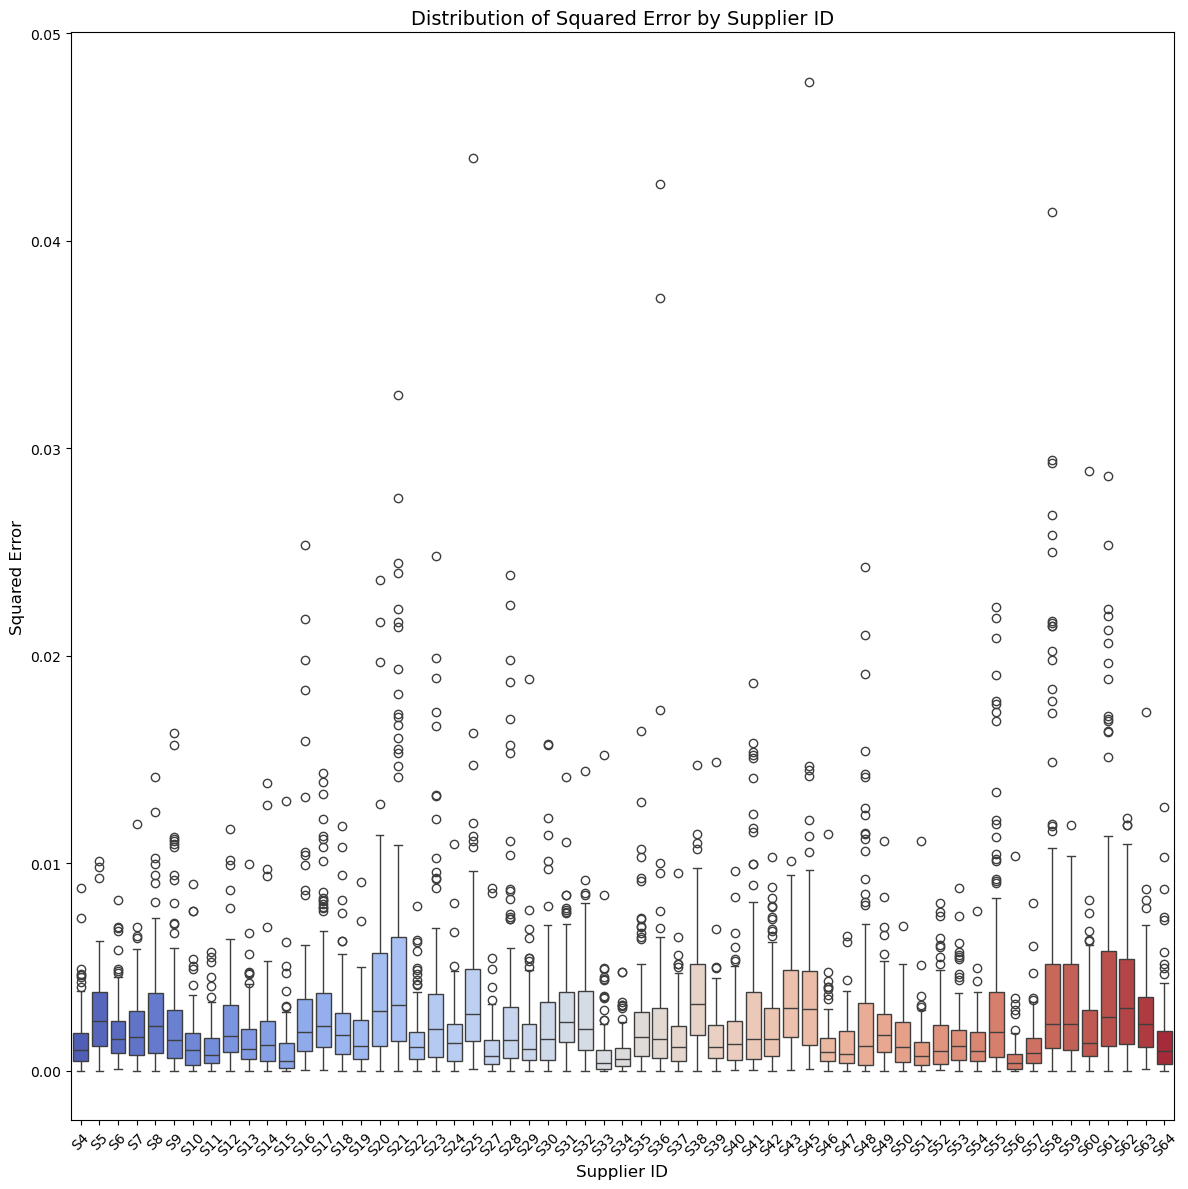

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 12))
sns.boxplot(data=error2_3, x='Supplier ID', y='Squared_Error', palette='coolwarm')

# Customize the plot
plt.title('Distribution of Squared Error by Supplier ID', fontsize=14)
plt.xlabel('Supplier ID', fontsize=12)
plt.ylabel('Squared Error', fontsize=12)
plt.xticks(rotation=45)  

plt.tight_layout()
plt.show()

Squared Error Distribution Graph

### 2.3.2. Equation (2)

In [15]:
RMSE_error2_3 = calculate_supplier_errors(cost)[1]
RMSE_error2_3 = RMSE_error2_3.sort_values('RMSE', ascending = True)

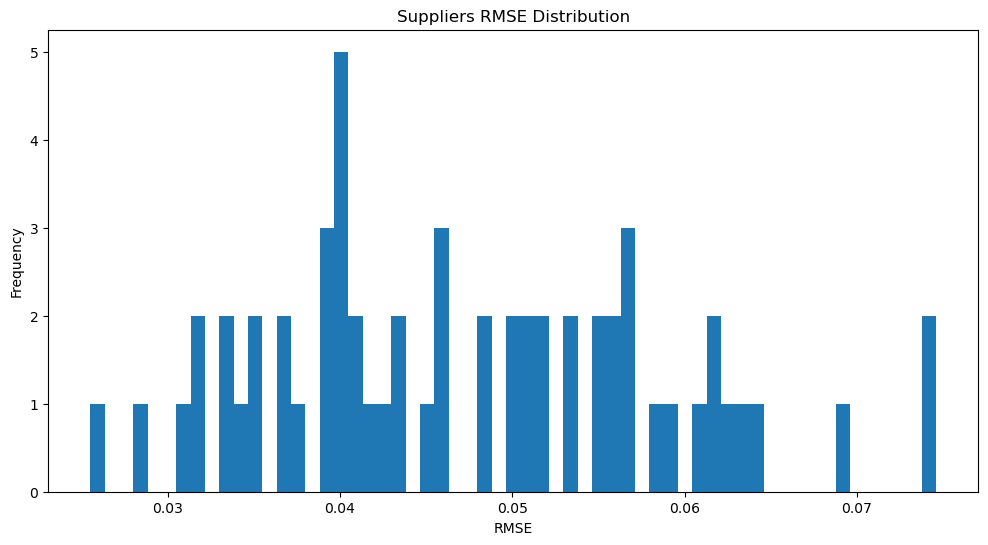


 The lowest RMSE supplier for all tasks is S56

 Best 5 suppliers (lowest RMSE):
   Supplier ID      RMSE
46         S56  0.025513
23         S34  0.028830
5          S15  0.030963
22         S33  0.031418
41         S51  0.032154

 Worst 5 suppliers (highest RMSE):
   Supplier ID      RMSE
11         S21  0.074572
48         S58  0.074036
52         S61  0.069511
10         S20  0.063861
15         S25  0.063245


In [17]:
# Visualization

plt.figure(figsize=(12, 6))
plt.hist(RMSE_error2_3['RMSE'], bins=59)
plt.title('Suppliers RMSE Distribution')
plt.xlabel('RMSE')
plt.ylabel('Frequency')

plt.show()

print(f"\n The lowest RMSE supplier for all tasks is {RMSE_error2_3.iloc[0,0]}")

print("\n Best 5 suppliers (lowest RMSE):")
print(RMSE_error2_3.nsmallest(5, 'RMSE'))

print("\n Worst 5 suppliers (highest RMSE):")
print(RMSE_error2_3.nlargest(5, 'RMSE'))



# 3. ML model fitting and scoring
* ML model fitting and scoring: In this step, you will need to split the data into input features and
output values. In addition, you will create training and testing datasets. One particularity of this
case study is that the same task appears in both training and testing, thus data must be grouped
by task when creating training and validation sets.

## 3.1. Combine data
* Combine the task features, supplier features and costs into a single dataset
* Each Task ID (and its corresponding feature values) will appear multiple times (once for
each supplier). The number of rows of this dataset must be the same as the number of rows
in ‘costs.csv’. Then split the dataset into X (TF1,…,TFn, SF1,…, SFm), y (Cost), and
Groups (Task ID). Note that there will be fewer task features (TFi ) than in the original data
because of the features removed in Step 1 above.

In [19]:
# Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import random

Just using the dataset from the data preparation file

In [21]:
tasks = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final-data/tasks.csv')
suppliers = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final-data/suppliers.csv')
cost = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final-data/cost.csv')

df = pd.read_csv('/Users/alexander/Documents/MSc Data Science/Python/Coursework/final-data/final_data.csv')
df = df.iloc[:,1:]
df

,Task ID,TF71,TF3,TF87,TF5,TF52,TF64,TF59,TF13,TF25,...,SF14,SF11,SF5,SF16,SF2,SF4,SF15,SF12,SF13,Cost
0,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-0.052632,-0.052632,-0.818182,0.2,-0.052632,-0.818182,-0.538462,0.142857,-0.052632,0.384386
1,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-1.000000,1.000000,1.000000,0.2,-0.052632,1.000000,1.000000,1.000000,1.000000,0.427075
2,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,1.000000,1.000000,1.000000,0.2,-1.000000,-1.000000,-0.538462,-1.000000,-1.000000,0.386642
3,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,-1.000000,-0.052632,-0.818182,1.0,1.000000,-1.000000,1.000000,0.142857,1.000000,0.392691
4,T1,0.03876,0.648543,-0.282124,0.074792,-0.596797,0.185185,0.148936,0.735664,0.718965,...,1.000000,-1.000000,-1.000000,1.0,-0.052632,-0.818182,-0.538462,0.142857,1.000000,0.434512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7075,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-1.000000,-1.000000,1.000000,0.2,-1.000000,-1.000000,-1.000000,1.000000,-0.052632,0.410605
7076,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,1.000000,-0.052632,-1.000000,-1.0,1.000000,-1.000000,-1.000000,-1.000000,-0.052632,0.410376
7077,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-0.052632,-1.000000,1.000000,0.2,-0.052632,-1.000000,-0.538462,1.000000,1.000000,0.407884
7078,T130,1.00000,0.357025,-0.076719,0.064291,-0.474234,-0.629630,-0.702128,0.359876,-0.537758,...,-0.052632,1.000000,1.000000,0.2,-0.052632,-0.818182,1.000000,-1.000000,-1.000000,0.420536


In [23]:
print('The number of rows in the costs dataframe were: ', cost.shape[0], \
      ' and the number of rows of the new dataframe is: ',df.shape[0])

The number of rows in the costs dataframe were:  7080  and the number of rows of the new dataframe is:  7080


Used a manual approach instead of test train split to keep the groups intact

In [25]:
# Splitting into test and train datasets, manually to preserve the groups

X = df.drop(['Task ID','Supplier ID','Cost'], axis='columns')
y = df['Cost']
Groups = df['Task ID']

## 3.2. Train test split
* Randomly select 20 unique ‘Task ID’ values from Groups (let’s call this subset TestGroup).
Split the dataset created in Step 3.1 into four different datasets (X_train, X_test,
y_train and y_test) as follows. X_train, X_test contain only the columns TF1,…,TFn,
SF1,…, SFm; whereas y_train,y_test contain only the column ‘Cost’. Also, X_test,
y_test contain only rows whose Task IDs are in TestGroup; whereas X_train, y_train
contain the remainder rows.

In [27]:
# Randomly select 20 groups
import random
random.seed(42)
TestGroup = random.sample(list(df['Task ID'].unique()), 20)
TestGroup

['T92',
 'T19',
 'T4',
 'T105',
 'T44',
 'T39',
 'T36',
 'T23',
 'T17',
 'T97',
 'T125',
 'T80',
 'T14',
 'T86',
 'T63',
 'T5',
 'T35',
 'T37',
 'T75',
 'T88']

In [29]:
# Also, X_test, y_test contain only rows whose Task IDs are in TestGroup
# whereas X_train, y_train contain the remainder rows

test = df[df['Task ID'].isin(TestGroup)].sort_values(by='Task ID').reset_index(drop=True)
train = df[~df['Task ID'].isin(TestGroup)].sort_values(by='Task ID').reset_index(drop=True)

In [31]:
test

,Task ID,TF71,TF3,TF87,TF5,TF52,TF64,TF59,TF13,TF25,...,SF14,SF11,SF5,SF16,SF2,SF4,SF15,SF12,SF13,Cost
0,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,-0.052632,-1.000000,-1.0,-0.052632,-1.000000,1.000000,1.000000,-0.052632,0.663162
1,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-1.000000,1.000000,1.000000,1.0,-0.052632,1.000000,1.000000,1.000000,-1.000000,0.661260
2,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,1.000000,-1.000000,-1.0,-0.052632,-0.818182,1.000000,-1.000000,1.000000,0.637136
3,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-1.000000,1.000000,-0.818182,0.2,1.000000,1.000000,1.000000,1.000000,1.000000,0.655428
4,T105,1.0,-1.00000,-1.00000,1.000000,-1.000000,1.000000,1.000000,0.324787,-0.805001,...,-0.052632,1.000000,1.000000,0.2,-0.052632,-0.818182,-1.000000,0.142857,1.000000,0.661384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1175,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-1.000000,-1.000000,-0.818182,1.0,-1.000000,-1.000000,-0.538462,-1.000000,-1.000000,0.425591
1176,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,1.000000,-0.052632,-1.000000,-1.0,-0.052632,1.000000,-0.538462,1.000000,-0.052632,0.495442
1177,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-1.000000,-1.000000,-0.818182,0.2,1.000000,-0.818182,-0.538462,1.000000,-1.000000,0.499862
1178,T97,1.0,0.01161,-0.29263,-0.469513,-0.520195,-0.407407,-0.914894,-0.104544,-0.614484,...,-0.052632,-0.052632,1.000000,0.2,1.000000,-0.818182,-1.000000,-1.000000,-0.052632,0.467556


In [33]:
len(test['Task ID'].unique())

20

In [35]:
test_loc = df['Task ID'].isin(list(TestGroup))
test_ids = df[test_loc]['Task ID'].to_numpy()

train_ids = df[~test_loc]['Task ID'].to_numpy()
train_tasks = df['Task ID'][~test_loc]

X_test = X[test_loc].to_numpy()
y_test = y[test_loc].to_numpy()
X_train = X[~test_loc].to_numpy()
y_train = y[~test_loc].to_numpy()

Fitting a simple Lasso regression model on the training data, R2 is not very impressive but its not negative so its something!

## 3.3. Train a regression ML model

* Score the performance of the model on the X_test and y_test using the score function of the model. When using a regression model, the ML model predicts the cost of each supplier for a given task, thus the supplier selected by the ML model in Eq. (1) is the one with the lowest predicted cost. Note that Eq. (1) uses the actual cost of the selected supplier, not the predicted cost

### 3.3.1. Lasso
* Lasso Regression (Lasso):
<br>Usage: Uses L1 regularization to perform feature selection.
<br>Pros: Can set coefficients to zero, eliminating unnecessary features.
<br>Cons: Can be computationally intensive with large datasets.

In [37]:
# Fitting Lasso regression model
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.001, random_state = 42, max_iter = 1000)
lasso.fit(X_train, y_train)

lasso_pred = lasso.predict(X_test)

lasso_score = lasso.score(X_test, y_test)  # R2 score
print('Lasso Score:', lasso_score)

Lasso Score: 0.5812920579314805


### 3.3.2. MLP Regressor

In [41]:
# Fitting MLP regression model

from sklearn.neural_network import MLPRegressor
np.random.seed(42)

mlp = MLPRegressor(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)

mlp_pred = mlp.predict(X_test)

mlp_score = mlp.score(X_test, y_test)  # R2 score
print('MLP Score:', mlp_score)

MLP Score: 0.6623913526459613


### 3.3.3. RandomForestRegression

In [43]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, random_state = 42, max_depth = 5)
rfr.fit(X_train, y_train)

rfr_pred = rfr.predict(X_test)

rfr_score = rfr.score(X_test, y_test)  # R2 score
print('RandomForestRegressor Score:', rfr_score)

RandomForestRegressor Score: 0.42774452039815236


### 3.3.4. Gradient Boosting Regression

In [45]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators = 100, random_state = 42)
gbr.fit(X_train, y_train)

gbr_pred = gbr.predict(X_test)

gbr_score = gbr.score(X_test, y_test)  # R2 score
print('GradientBoostingRegressor Score:', gbr_score)

GradientBoostingRegressor Score: 0.5038735847334708


## 3.4. Calculate the error

* Using Eq. (1) calculate the Error of the trained model for each task in TestGroup and using
Eq. (2), calculate the RMSE score.

(Charlie) Manuel suggested we should be using numpy instead of pandas for the error functions, apart from that I've tried to keep it simple
rmse_calc is just a useful function to compute our RMSE scores, it doesn't go into the models at all

Error calculation is slightly more involved for the held out part, because the tasks used for testing are all together initially, so we have to split perform it for each task

In [47]:
# Error caculation tables

test_df = test.loc[:,['Task ID', 'Supplier ID', 'Cost']]

# Actual min cost
test_df = test_df.set_index('Task ID')
test_df['Min Cost'] = test_df.groupby('Task ID')['Cost'].min()

# Min cost predicted by ML models
test_df['Predicted Cost_lasso'] = lasso_pred
test_df['Predicted Cost_mlp'] = mlp_pred
test_df['Predicted Cost_rfr'] = rfr_pred
test_df['Predicted Cost_gbr'] = gbr_pred
test_df

,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Predicted Cost_mlp,Predicted Cost_rfr,Predicted Cost_gbr
Task ID,,,,,,,
T105,S49,0.663162,0.557944,0.377543,0.353650,0.433326,0.426788
T105,S35,0.661260,0.557944,0.380210,0.328113,0.435624,0.429647
T105,S36,0.637136,0.557944,0.377672,0.368786,0.435491,0.430148
T105,S37,0.655428,0.557944,0.375988,0.305730,0.433733,0.429084
T105,S38,0.661384,0.557944,0.380931,0.368711,0.433774,0.437318
...,...,...,...,...,...,...,...
T97,S30,0.425591,0.421872,0.430869,0.434573,0.422999,0.414341
T97,S31,0.495442,0.421872,0.442226,0.439705,0.422999,0.419074
T97,S32,0.499862,0.421872,0.444949,0.402750,0.422999,0.418236


### 3.4.1. LASSO

In [49]:
# The lowest predicted cost_lasso of each task
test_df_lasso = test_df.iloc[:,[0,1,2,3]]

test_df_lasso = test_df_lasso.reset_index()

test_df_lasso = (
    test_df_lasso.sort_values(by='Predicted Cost_lasso')
    .drop_duplicates(subset='Task ID') 
    .set_index('Task ID')
)
# Eq(1) Create 'Error' column
test_df_lasso['Error_lasso'] = test_df_lasso['Min Cost'] - test_df_lasso['Cost']

# Eq(2) RMSE
test_df_lasso['Error_Squared_lasso'] = test_df_lasso['Error_lasso']**2
MSE_lasso = np.sum(test_df_lasso['Error_Squared_lasso'])/len(test_df_lasso.index.unique())

RMSE_lasso = np.sqrt(MSE_lasso)
print(f"LASSO RMSE : {RMSE_lasso}")

# R2 score
lasso_score = lasso.score(X_test, y_test) 
print(f"LASSO Score: {lasso_score}")

test_df_lasso

LASSO RMSE : 0.04754969801983095
LASSO Score: 0.5812920579314805


,Supplier ID,Cost,Min Cost,Predicted Cost_lasso,Error_lasso,Error_Squared_lasso
Task ID,,,,,,
T23,S19,0.362180,0.305738,0.336258,-0.056442,0.003186
T39,S18,0.365488,0.321541,0.346366,-0.043946,0.001931
T14,S19,0.370688,0.301029,0.346948,-0.069659,0.004852
T4,S64,0.415566,0.350738,0.349212,-0.064829,0.004203
T37,S18,0.341911,0.307787,0.352833,-0.034124,0.001164
T19,S33,0.344680,0.309074,0.359697,-0.035606,0.001268
T17,S18,0.352149,0.321380,0.363523,-0.030769,0.000947
T36,S18,0.359490,0.284575,0.368905,-0.074915,0.005612
T105,S18,0.598734,0.557944,0.371826,-0.040789,0.001664


### 3.4.2. MLP

In [51]:
# The lowest predicted cost_mlp of each task
test_df_mlp = test_df.iloc[:,[0,1,2,4]]

test_df_mlp = test_df_mlp.reset_index()

test_df_mlp = (
    test_df_mlp.sort_values(by='Predicted Cost_mlp')
    .drop_duplicates(subset='Task ID') 
    .set_index('Task ID')
)
# Eq(1) Create 'Error' column
test_df_mlp['Error_mlp'] = test_df_mlp['Min Cost'] - test_df_mlp['Cost']

# Eq(2) RMSE
test_df_mlp['Error_Squared_mlp'] = test_df_mlp['Error_mlp']**2
MSE_mlp = np.sum(test_df_mlp['Error_Squared_mlp'])/len(test_df_mlp.index.unique())

RMSE_mlp = np.sqrt(MSE_mlp)
print(f"MLP RMSE : {RMSE_mlp}")

# R2 score
mlp_score = mlp.score(X_test, y_test) 
print(f"MLP Score: {mlp_score}")

test_df_mlp

MLP RMSE : 0.05152114176186075
MLP Score: 0.6623913526459613


,Supplier ID,Cost,Min Cost,Predicted Cost_mlp,Error_mlp,Error_Squared_mlp
Task ID,,,,,,
T105,S52,0.632040,0.557944,0.185867,-0.074095,0.005490
T35,S35,0.307174,0.283752,0.240811,-0.023422,0.000549
T19,S27,0.341957,0.309074,0.280051,-0.032883,0.001081
T17,S27,0.384859,0.321380,0.282455,-0.063480,0.004030
T23,S42,0.350344,0.305738,0.288411,-0.044606,0.001990
T4,S28,0.441775,0.350738,0.297967,-0.091037,0.008288
T14,S9,0.377430,0.301029,0.298995,-0.076401,0.005837
T37,S25,0.326588,0.307787,0.306870,-0.018801,0.000353
T36,S30,0.326435,0.284575,0.307812,-0.041860,0.001752


### 3.4.3. RandomForestRegressor

In [53]:
# The lowest predicted cost_rfr of each task
test_df_rfr = test_df.iloc[:,[0,1,2,5]]

test_df_rfr = test_df_rfr.reset_index()

test_df_rfr = (
    test_df_rfr.sort_values(by='Predicted Cost_rfr')
    .drop_duplicates(subset='Task ID') 
    .set_index('Task ID')
)
# Eq(1) Create 'Error' column
test_df_rfr['Error_rfr'] = test_df_rfr['Min Cost'] - test_df_rfr['Cost']

# Eq(2) RMSE
test_df_rfr['Error_Squared_rfr'] = test_df_rfr['Error_rfr']**2
MSE_rfr = np.sum(test_df_rfr['Error_Squared_rfr'])/len(test_df_rfr.index.unique())

RMSE_rfr = np.sqrt(MSE_rfr)
print(f"RandomForestRegressor RMSE : {RMSE_rfr}")

# R2 score
rfr_score = rfr.score(X_test, y_test) 
print(f"RandomForestRegressor Score: {rfr_score}")

test_df_rfr

RandomForestRegressor RMSE : 0.05495737001859475
RandomForestRegressor Score: 0.42774452039815236


,Supplier ID,Cost,Min Cost,Predicted Cost_rfr,Error_rfr,Error_Squared_rfr
Task ID,,,,,,
T4,S10,0.383651,0.350738,0.335865,-0.032913,0.001083
T39,S41,0.393500,0.321541,0.339968,-0.071959,0.005178
T37,S41,0.324029,0.307787,0.343789,-0.016242,0.000264
T17,S41,0.444063,0.321380,0.345703,-0.122683,0.015051
T19,S40,0.345376,0.309074,0.345703,-0.036302,0.001318
T35,S8,0.299798,0.283752,0.347980,-0.016047,0.000258
T14,S28,0.370487,0.301029,0.349553,-0.069458,0.004824
T23,S28,0.356245,0.305738,0.359607,-0.050507,0.002551
T36,S27,0.340902,0.284575,0.376083,-0.056327,0.003173


### 3.4.4. GradientBoostingRegressor

In [55]:
# The lowest predicted cost_gbr of each task
test_df_gbr = test_df.iloc[:,[0,1,2,6]]

test_df_gbr = test_df_gbr.reset_index()

test_df_gbr = (
    test_df_gbr.sort_values(by='Predicted Cost_gbr')
    .drop_duplicates(subset='Task ID') 
    .set_index('Task ID')
)
# Eq(1) Create 'Error' column
test_df_gbr['Error_gbr'] = test_df_gbr['Min Cost'] - test_df_gbr['Cost']

# Eq(2) RMSE
test_df_gbr['Error_Squared_gbr'] = test_df_gbr['Error_gbr']**2
MSE_gbr = np.sum(test_df_gbr['Error_Squared_gbr'])/len(test_df_gbr.index.unique())

RMSE_gbr = np.sqrt(MSE_gbr)
print(f"GradientBoostingRegressor RMSE : {RMSE_gbr}")

# R2 score
gbr_score = gbr.score(X_test, y_test) 
print(f"GradientBoostingRegressor Score: {gbr_score}")

test_df_gbr

GradientBoostingRegressor RMSE : 0.0495478585599979
GradientBoostingRegressor Score: 0.5038735847334708


,Supplier ID,Cost,Min Cost,Predicted Cost_gbr,Error_gbr,Error_Squared_gbr
Task ID,,,,,,
T39,S27,0.344857,0.321541,0.321740,-0.023316,0.000544
T4,S25,0.418945,0.350738,0.325132,-0.068207,0.004652
T19,S27,0.341957,0.309074,0.325714,-0.032883,0.001081
T17,S27,0.384859,0.321380,0.326763,-0.063480,0.004030
T14,S28,0.370487,0.301029,0.328444,-0.069458,0.004824
T37,S27,0.335377,0.307787,0.328932,-0.027590,0.000761
T35,S27,0.308655,0.283752,0.331597,-0.024904,0.000620
T23,S28,0.356245,0.305738,0.334802,-0.050507,0.002551
T36,S27,0.340902,0.284575,0.347247,-0.056327,0.003173


In [57]:
# For just Reference  (We can delete it!)

print('RMSE by sklearn: ')
from sklearn.metrics import root_mean_squared_error

lasso_rmse = root_mean_squared_error(y_test, lasso_pred)
mlp_rmse = root_mean_squared_error(y_test, mlp_pred)
rfr_rmse = root_mean_squared_error(y_test, rfr_pred)
gbr_rmse = root_mean_squared_error(y_test, gbr_pred)

print('lasso_rmse', lasso_rmse)
print('mlp_rmse', mlp_rmse)
print('rfr_rmse', rfr_rmse)
print('gbr_rmse', gbr_rmse)

RMSE by sklearn: 
lasso_rmse 0.04921049983463073
mlp_rmse 0.04418846930854312
rfr_rmse 0.0575303686343084
gbr_rmse 0.05356712676212233


## 3.5. Compare Errors and RMSE
* Compare to the values obtained in Step 2.3 and summarise your
conclusions.

# Please read this sentence below!! (Sue)
Differences in RMSE Calculation and Purpose:
Problem 2.3 focuses on "comparison between suppliers," while problems 3.5 and 4 concentrate on "model selection performance for each task."
Consequently, the RMSE used in each problem evaluates different perspectives.
<br>
Validity of Comparison:
It is strictly speaking inappropriate to directly compare the RMSE calculated in 2.3 with those calculated in 3.5 and 4. This is because 2.3 assumes a "fixed supplier for all tasks" scenario, whereas 3.5 and 4 consider "task-specific optimization."

*In 2.3, we evaluated the overall cost competitiveness of suppliers, while in 3.5 and 4, we assessed the supplier selection performance for each task*

### 3.5.1. Error_Squared distribution boxplot

In [59]:
print(f"The lowest RMSE supplier is {RMSE_error2_3.iloc[0,0]} and the RMSE is {RMSE_error2_3.iloc[0,1]}")

The lowest RMSE supplier is S56 and the RMSE is 0.025513031887435957


1) Based on 1.3.1 the best supplier is  S33,  (the top performing supplier)
2) Based on 2.3, the best supplier is S56  (the lowest RMSE in all tasks)

We'll evaluate each ML model's score w/ S56 RMSE

In [61]:
error2_3 = error2_3[error2_3['Task ID'].isin(TestGroup)]
error_S56 = error2_3[error2_3['Supplier ID'] == 'S56'].set_index('Task ID')

error_S56

,Supplier ID,Min Cost,Supplier Cost,Error,Squared_Error
Task ID,,,,,
T35,S56,0.283752,0.314018,-0.030266,0.000916
T36,S56,0.284575,0.308774,-0.024199,0.000586
T17,S56,0.321380,0.321380,0.000000,0.000000
T19,S56,0.309074,0.310650,-0.001576,0.000002
T14,S56,0.301029,0.311437,-0.010409,0.000108
T23,S56,0.305738,0.318635,-0.012897,0.000166
T4,S56,0.350738,0.355370,-0.004632,0.000021
T5,S56,0.426786,0.444963,-0.018177,0.000330
T37,S56,0.307787,0.314754,-0.006967,0.000049


In [63]:
# Error_Squared boxplot

error_S56_squared = error_S56['Squared_Error']
test_df_lasso_squared = test_df_lasso['Error_Squared_lasso']
test_df_mlp_squared = test_df_mlp['Error_Squared_mlp']
test_df_rfr_squared = test_df_rfr['Error_Squared_rfr']
test_df_gbr_squared = test_df_gbr['Error_Squared_gbr']

Error_squared_data = pd.DataFrame({'S56': error_S56_squared,
                                   'lasso' : test_df_lasso_squared,
                                   'mlp': test_df_mlp_squared,
                                   'rfr': test_df_rfr_squared,
                                   'gbr': test_df_gbr_squared})
Error_squared_data

,S56,lasso,mlp,rfr,gbr
Task ID,,,,,
T105,0.010357,0.001664,0.005490,0.008749,0.003674
T125,0.000246,0.001321,0.002630,0.000246,0.002631
T14,0.000108,0.004852,0.005837,0.004824,0.004824
T17,0.000000,0.000947,0.004030,0.015051,0.004030
T19,0.000002,0.001268,0.001081,0.001318,0.001081
T23,0.000166,0.003186,0.001990,0.002551,0.002551
T35,0.000916,0.000548,0.000549,0.000258,0.000620
T36,0.000586,0.005612,0.001752,0.003173,0.003173
T37,0.000049,0.001164,0.000353,0.000264,0.000761


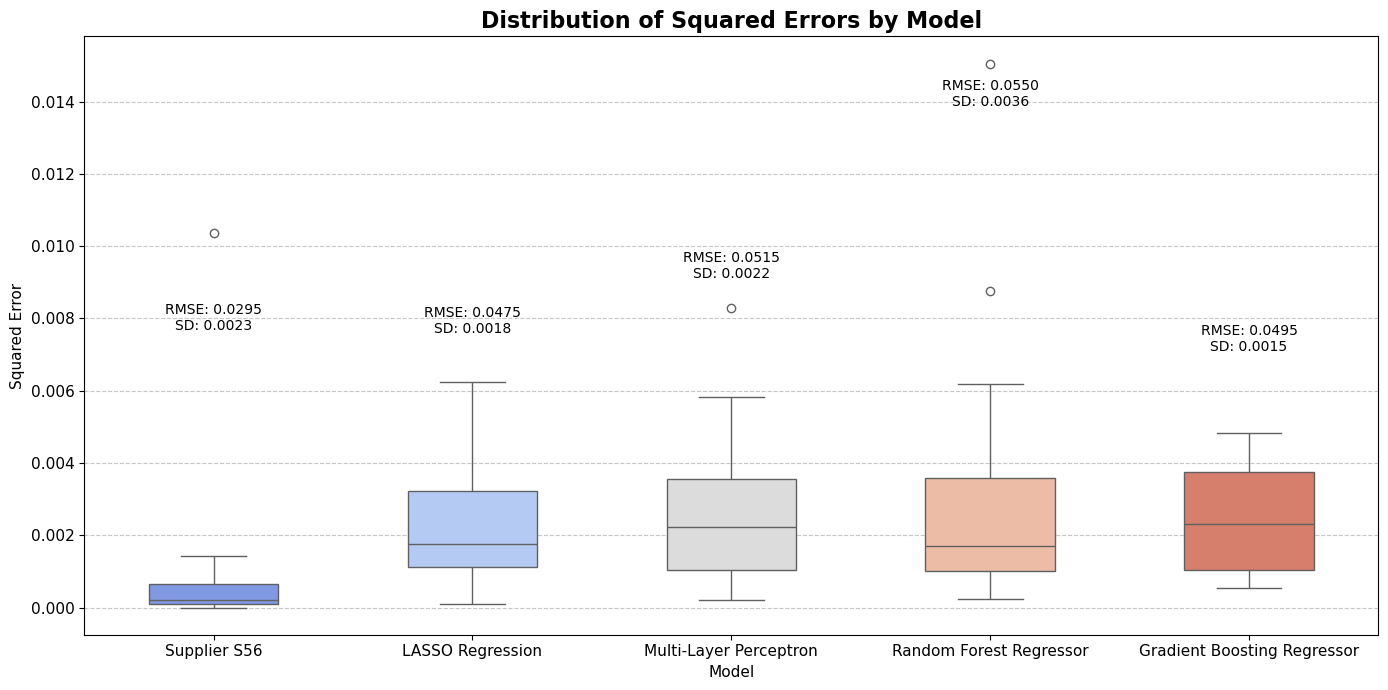

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Map short names to full names
full_names = {
    "S56": "Supplier S56",
    "lasso": "LASSO Regression",
    "mlp": "Multi-Layer Perceptron",
    "rfr": "Random Forest Regressor",
    "gbr": "Gradient Boosting Regressor"
}

# Update column names in DataFrame
Error_squared_data = Error_squared_data.rename(columns=full_names)

# Create the boxplot
plt.figure(figsize=(14, 7))
sns.boxplot(data=Error_squared_data, palette="coolwarm", width=0.5)

# Add title and axis labels
plt.title("Distribution of Squared Errors by Model", fontsize=16, fontweight="bold")
plt.xlabel("Model", fontsize=11)
plt.ylabel("Squared Error", fontsize=11)

# Annotate RMSE and standard deviation above each boxplot
for i, column in enumerate(Error_squared_data.columns):
    mse = Error_squared_data[column].mean()  # Mean Squared Error
    rmse = np.sqrt(mse)  # Root Mean Squared Error (RMSE)
    std_val = Error_squared_data[column].std()  # Standard deviation
    plt.text(i, mse + std_val * 3, f"RMSE: {rmse:.4f}\nSD: {std_val:.4f}",
             ha="center", fontsize=10, color="black")

# Rotate x-axis labels for better readability
plt.xticks(fontsize=11, ha="center")
plt.yticks(fontsize=11)

# Add gridlines for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Adjust layout for clarity
plt.tight_layout()

plt.savefig("mse-compar.png", format="png", dpi=300)

# Show the plot
plt.show()


### 3.5.2. RMSE comparison

In [106]:
# Eq(2) RMSE

RMSE_S56 = np.sqrt(np.sum(Error_squared_data.iloc[:,0])/len(Error_squared_data.index.unique()))

# Create the RMSE table
RMSE_table = pd.DataFrame({
    'Model': ['S56', 'Lasso', 'MLP', 'RFR', 'GBR'],
    'RMSE': [RMSE_S56, RMSE_lasso, RMSE_mlp, RMSE_rfr, RMSE_gbr]
})

RMSE_table

,Model,RMSE
0,S56,0.029471
1,Lasso,0.047550
2,MLP,0.051521
3,RFR,0.054957
4,GBR,0.049548


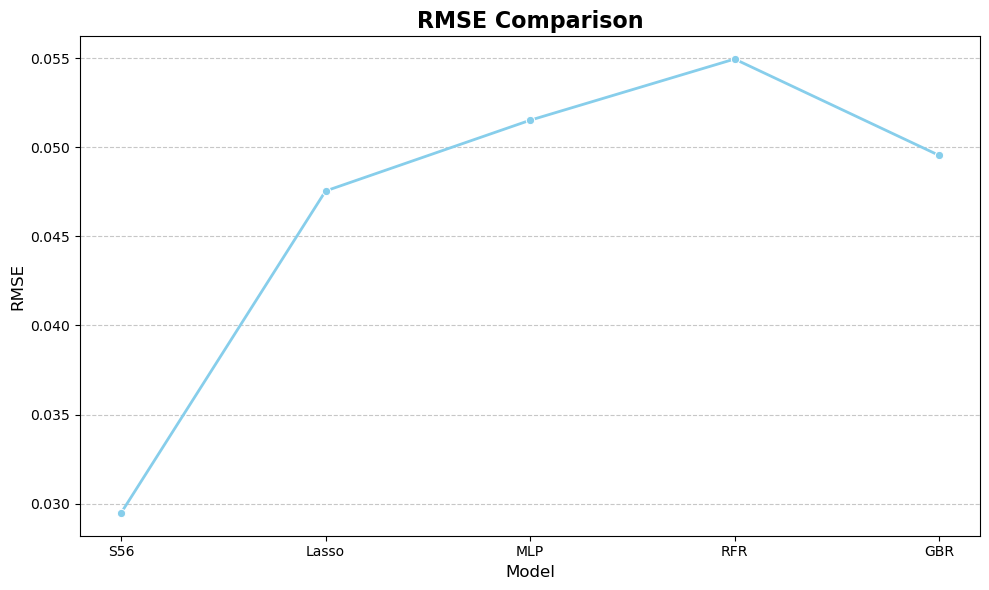

In [108]:
# 2. RMSE Lineplot

plt.figure(figsize=(10, 6))
sns.lineplot(RMSE_table, x='Model', y='RMSE', marker='o', linewidth=2, color='skyblue')

plt.title('RMSE Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# 4. Cross-Validation

In [125]:
def error_function(y_true, y_pred):
    """
    Custom error function based on Equation 1:
    Error(t) = min{c(s, t) | s ∈ S} - c(s_t', t)

    Parameters:
    - y_true: Array of true costs for all suppliers for a task (includes Min Cost).
    - y_pred: Predicted cost by the ML model for the selected supplier.

    Returns:
    - Mean error across all test samples in the fold.
    """
    errors = []
    
    for i in range(len(y_true)):
        # True minimum cost for this task
        min_cost = np.min(y_true[i])
        
        # Predicted cost by the model for the selected supplier
        predicted_cost = y_pred[i]
        
        # Compute the error
        error = min_cost - predicted_cost
        errors.append(error)
    
    # Return the mean error across all samples in this test set
    return np.mean(errors)


In [129]:
from sklearn.model_selection import LeaveOneGroupOut, cross_val_score
from sklearn.metrics import make_scorer

logo = LeaveOneGroupOut()
error_scorer = make_scorer(error_function)

lasso_cv = Lasso(alpha=0.001)
cv_scores = cross_val_score(lasso_cv, X_train, y_train, cv=logo, groups=train_tasks, scoring=error_scorer)

In [131]:
test_df_gbr['Error_gbr'] = test_df_gbr['Min Cost'] - test_df_gbr['Cost']

# Eq(2) RMSE
test_df_gbr['Error_Squared_gbr'] = test_df_gbr['Error_gbr']**2
MSE_gbr = np.sum(test_df_gbr['Error_Squared_gbr'])/len(test_df_gbr.index.unique())

RMSE_gbr = np.sqrt(MSE_gbr)
print(f"GradientBoostingRegressor RMSE : {RMSE_gbr}")

GradientBoostingRegressor RMSE : 0.0495478585599979


In [133]:
print(rmse_calc(cv_scores))

NameError: name 'rmse_calc' is not defined

We only see predictive accuracy of any kind with tiny alpha values, but it does form a ranking which is the main thing
Takes about 5 minutes to run for me, so bear that in mind

In [148]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

lasso_hp = Lasso()
params = {'alpha': np.linspace(0.001, 0.0001, 100)}

grid_search = GridSearchCV(lasso_hp, param_grid=params, scoring=error_scorer, cv=logo, n_jobs=-1)
grid_search.fit(X_train, y_train, groups=train_tasks)
lasso_hp_results = pd.DataFrame(grid_search.cv_results_)

Picks out a very very small alpha value, but at least it picks one

In [150]:
print(grid_search.best_params_)

{'alpha': 0.00037272727272727273}


Next job is report to fit the model for the chosen hyperparameters, report the rmse, copy paste the code for a new regression model, maybe MLP? and get some simple viz of the results

In [154]:
grid_search.best_params_['alpha']

0.00037272727272727273

In [156]:
lasso_hp = Lasso(alpha=grid_search.best_params_['alpha'])
lasso_hp.fit(X_train, y_train)
print(lasso_hp.score(X_test,y_test))
y_pred = lasso_hp.predict(X_test)

0.5462614126570942


In [158]:
hp_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    hp_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

-0.023997590206996378
-0.01886495931830251
-0.018176695386359243
-0.006408969222048588
-0.011245950423476758
-0.0104726223705211
-0.02762685539882359
-0.033259263796944605
0.0
-0.007138839421870102
-0.025453823409779752
-0.0345263004921727
-0.010408508583130804
-0.019862313243964813
-0.0333538663567397
0.0
-0.010170413261649969
-0.0006968233468558904
-0.05661013824413952
-0.019587667953720522


In [160]:
print(rmse_calc(hp_errors))

0.02302972973273373


We see a pretty big improvement on our initital alpha choice, thank god!

Now we're repeating the process for MLP, the code is completely symmetrical to the Lasso case except for the parameters

In [164]:
# 3.3 Fitting an MLP regression model
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(100,100))
mlp.fit(X_train, y_train)
print(mlp.score(X_test,y_test))
y_pred = mlp.predict(X_test)

0.1962823294782805


In [166]:
mlp_h_o_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    mlp_h_o_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

print(rmse_calc(mlp_h_o_errors))

-0.025894681877737302
-0.030271842966113183
-0.030514605516835935
-0.006408969222048588
-0.011426437843547299
-0.03660749074221148
-0.021544021713750916
-0.05801817496592848
-0.025440561555003904
0.0
-0.015614183915045654
-0.06547873147302269
-0.02181652419831842
-0.021210992012478613
-0.01823508720918121
-0.03743738262150048
-0.024029883872227098
-0.001982766080626086
-0.04302513198576374
-0.018625472939890086
0.03039566535358474


In [168]:
logo = LeaveOneGroupOut()
error_scorer = make_scorer(error_function)

mlp_cv = MLPRegressor(hidden_layer_sizes=(100,100))
cv_scores = cross_val_score(mlp_cv, X_train, y_train, cv=logo, groups=train_tasks, scoring=error_scorer)

In [170]:
print(rmse_calc(cv_scores))

0.0320612509829627


Works but maybe would change the hidden layer sizes we offer, don't get a very big performance improvement

In [173]:
mlp_hp = MLPRegressor()
params = {'hidden_layer_sizes': [(100,100),(50,50,50),(200)],
          'solver': ['lbfgs', 'sgd', 'adam']}

grid_search_mlp = GridSearchCV(mlp_hp, param_grid=params, scoring=error_scorer, cv=logo, n_jobs=-1)
grid_search_mlp.fit(X_train, y_train, groups=train_tasks)
mlp_hp_results = pd.DataFrame(grid_search_mlp.cv_results_)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [175]:
print(grid_search_mlp.best_params_)

{'hidden_layer_sizes': 200, 'solver': 'lbfgs'}


In [177]:
mlp_hp = MLPRegressor(hidden_layer_sizes=grid_search_mlp.best_params_['hidden_layer_sizes'],
                      solver=grid_search_mlp.best_params_['solver'])
mlp_hp.fit(X_train, y_train)
print(mlp_hp.score(X_test,y_test))
y_pred = mlp_hp.predict(X_test)

0.6072991443863579


In [179]:
mlp_hp_errors = []
for i in TestGroup:
    task_trues = y_test[test_ids == i]
    task_preds = y_pred[test_ids == i]
    mlp_hp_errors.append(error_function(task_trues, task_preds))
    print(error_function(task_trues, task_preds))

-0.016181261818858483
-0.020898605623685618
-0.018176695386359243
-0.013550131502406582
-0.029796021793397964
-0.03275120473185139
-0.015991979187916894
-0.033259263796944605
-0.013177836730864811
0.0
-0.021170850114500872
-0.0713267179265189
-0.010408508583130804
0.0
-0.018833061948957452
-0.03743738262150048
-0.01276878248146518
-0.0006968233468558904
-0.04302513198576374
-0.02391103784115678


In [181]:
print(rmse_calc(mlp_hp_errors))

0.02710656429823698
